In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sc_stats
import json
import random
import seaborn as sns
import re

import spacy

# Text analysis
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SpanishStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('tokenizers/punkt/spanish.pickle')
nltk.download('stopwords')

import unicodedata

from wordcloud import WordCloud, STOPWORDS

from sklearn.linear_model import LinearRegression

import analysis_utils as aute

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jose\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading tokenizers/punkt/spanish.pickle: Package
[nltk_data]     'tokenizers/punkt/spanish.pickle' not found in index
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
rdm_th = 0
corr_th = 0.85

nlp_spanish = spacy.load("es_core_news_sm")

random.seed(rdm_th)

In [3]:
with open('../LableniBotConfig/avoid_words.json', encoding='utf-8') as fh:
    avoid_words_list = json.load(fh)

tokenize_spanish = nltk.data.load('tokenizers/punkt/spanish.pickle')
spanish_stemmer = SpanishStemmer()
spanish_stopwords_th = stopwords.words('spanish')

In [4]:
def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

Only conversations with more than 5 sentences are taken in account.

In [5]:
path_to_convs = "../Conversations/"

all_df_list = []
for subj in os.listdir(path_to_convs):
    for file_subj in os.listdir(path_to_convs + subj):
        if subj in file_subj:
            path_to_subj_conv = path_to_convs + subj + "/" + file_subj
            pkl_name = [file for file in os.listdir(path_to_subj_conv) if ".csv" in file][0]
            # print(pkl_name)
            try:
                df_x = pd.read_csv(path_to_subj_conv + "/" + pkl_name, sep=";")
                if df_x.shape[0] > 2:
                    all_df_list.append(df_x)
            except:
                print("Bad subject", path_to_subj_conv + "/" + pkl_name)
            
print("Number of conversations:", len(all_df_list))

Number of conversations: 10


In [6]:
def clean_word(word):
    special_characters = ["?", "¿", "!", "¡", ".", ","]
    w_new = word.lower()
    for s_c in special_characters:
        w_new = w_new.replace(s_c, "")
        
    return w_new

def avoid_words_func(text):
    return " ".join([w for w in text.split() if clean_word(w) not in avoid_words_list])

def clean_text(text, subject_name, 
               tokenize_spanish=tokenize_spanish, 
               spanish_stopwords_th=spanish_stopwords_th, 
               spanish_stemmer=spanish_stemmer, 
               use_stemmer=True):
    
    text = text.lower()
    text = text.replace('?', "").replace('¿', "").replace('!', "").replace('¡', "")
    if subject_name:
        text = text.replace(subject_name, "")
    text = strip_accents(text)
    
    text_token_list = []
    if use_stemmer:
        for word in text.split():
            token_text = tokenize_spanish.tokenize(word)
            if len(token_text) > 0 and word not in spanish_stopwords_th:
                text_token_list.append(spanish_stemmer.stem(token_text[0]))
    else:
        text_token_list.append(text)
            
    text = " ".join(text_token_list)
    
    return text

In [7]:
def include_time_columns(data, col_name_init, col_name_end, label):
    
    delta_time = data[col_name_end] - data[col_name_init]

    return {
        "Mean_" + label: np.nanmean(delta_time),
        "Max_" + label: np.nanmax(delta_time),
        "Min_" + label: np.nanmin(delta_time),
        "Diff_" + label: delta_time.dropna().iloc[-1] - delta_time.dropna().iloc[0],
    }


def get_text_metrics(data, subject_name, label):
        
    text = ". ".join(data["SpanishMessage"].values)
    my_clean_text = clean_text(text, subject_name)
    
    num_words_text = len(my_clean_text.split(" "))

    dict_results = {
        label + "Text": avoid_words_func(my_clean_text),
        label + "NumUniqWords": len(set([w for w in my_clean_text.split() if w.isalpha()])),
        label + "OriginalText": avoid_words_func( ". ".join(data["SpanishMessage"].values) ),
        label + "NumWords": num_words_text,
    }

    return dict_results

In [8]:
save_res_list = []
for i_df_x, df_x in enumerate(all_df_list):
    
    result_dict = {}

    subject_name = df_x["SubjectId"].iloc[0]
    
    # ###############
    # ### General ###
    # ###############
    num_conv = df_x.shape[0] // 2
    
    text = ". ".join(df_x["SpanishMessage"].values)
    whole_text = clean_text(text, subject_name)
    
    num_words = len(whole_text.split(" "))
    conv_time_s = df_x["UnixTimeSave"].iloc[-1] - df_x["UnixTimestampLoopInit"].iloc[0]
    # freq_conv_s = np.mean(df_x["unixtimestamp"].values[1:] - df_x["unixtimestamp"].values[:-1])
    
    result_dict["SubjectId"] = df_x["SubjectId"].iloc[0]
    result_dict["ConfigName"] = df_x["ConfigName"].iloc[0]
    result_dict["BotPersonality"] = df_x["ConfigName"].iloc[0].split("_")[0]
    result_dict["FirstDate"] = df_x["UnixTimestampLoopInit"].iloc[0]
    result_dict["LastDate"] = df_x["S2TEndUnix"].iloc[-1]
    result_dict["ConvTime_s"] = conv_time_s

    result_dict["NumConv"] = num_conv
    result_dict["NumSamples"] = df_x.shape[0]

    x = get_text_metrics(data=df_x, subject_name=subject_name, label="All")
    result_dict.update(x)

    # ###########
    # ### Bot ###
    # ###########
    df_bot = df_x[df_x["Source"] == "Bot"]

    x = get_text_metrics(data=df_bot, subject_name=subject_name, label="Bot")
    result_dict.update(x)

    dict_time_openai = include_time_columns(data=df_bot, col_name_init="BotStartUnix", col_name_end="BotEndUnix", label="OpenAI")
    dict_time_aws = include_time_columns(data=df_bot, col_name_init="AWSStartUniX", col_name_end="AWSEndUniX", label="AWS")
    dict_time_bottalk = include_time_columns(data=df_bot, col_name_init="BotTalkStartUnix", col_name_end="BotTalkEndUnix", label="BotTalk")

    # ##############
    # ### Person ###
    # ##############
    df_person = df_x[df_x["Source"] == "Person"]

    x = get_text_metrics(data=df_person, subject_name=subject_name, label="Person")
    result_dict.update(x)
    
    dict_time_s2t = include_time_columns(data=df_person, col_name_init="S2TStartUnix", col_name_end="S2TEndUnix", label="OpenAI")
    dict_time_pertalk = include_time_columns(data=df_person, col_name_init="PersonTalkStartUnix", col_name_end="PersonTalkEndUnix", label="PersonTalk")

    # ### Save the rest of times computed ###

    result_dict.update(dict_time_openai)
    result_dict.update(dict_time_aws)
    result_dict.update(dict_time_bottalk)
    result_dict.update(dict_time_pertalk)
    result_dict.update(dict_time_s2t)

    save_res_list.append(result_dict)
    
df_save = pd.DataFrame(save_res_list)
df_save.head(5)

,SubjectId,ConfigName,BotPersonality,FirstDate,LastDate,ConvTime_s,NumConv,NumSamples,AllText,AllNumUniqWords,...,Min_AWS,Diff_AWS,Mean_BotTalk,Max_BotTalk,Min_BotTalk,Diff_BotTalk,Mean_PersonTalk,Max_PersonTalk,Min_PersonTalk,Diff_PersonTalk
0,Jose112,Neutral_Female_1,Neutral,1.668100e+09,1.668100e+09,211.258012,13,26,"hola, nombr llam tu. hola, acab habl herman ge...",34,...,0.121264,-0.356831,4.598610,6.739621,0.937706,-2.982614,7.409874,9.773749,6.341515,3.367318
1,PilotoCasa1,Neutral_Female_2,Neutral,1.668250e+09,1.668250e+09,265.215356,12,24,"hola, nombr laur llam tu. hol laur llam tal es...",56,...,0.125686,-0.322621,7.011800,10.467074,4.074837,1.551315,9.794467,13.322500,6.341217,0.016310
2,PilotoCasa1,Happy_Man_1,Happy,1.668250e+09,1.668251e+09,212.271927,10,20,"encant conocerte, nombr javi nombre. hol javi ...",56,...,0.085300,-0.324654,5.953382,9.958347,1.728499,-4.354185,9.477151,13.391060,6.344173,0.016603
3,Piloto_01_CB,Neutral_Female_1,Neutral,1.668167e+09,NaN,221.379484,8,17,"hola, nombr llam tu. hola, tal llam jesus. bie...",60,...,0.106715,-0.292892,7.792385,14.376367,3.158752,-0.723917,12.914308,15.702672,6.216488,9.486184
4,Piloto_01_CB,Neutral_Male_2,Neutral,1.668167e+09,NaN,259.360775,9,19,"hola, nombr alejandr llam tu. jesus estas. bie...",75,...,0.064549,-0.215964,9.336640,13.395571,5.425617,1.381253,12.856639,18.848850,6.215110,6.276427


In [9]:
print("Shape", df_save.shape)
print("Columns", df_save.columns)
print("Number of subjects", df_save["SubjectId"].nunique())
print("Number of different chatbots", df_save["ConfigName"].nunique())

Shape (10, 36)
Columns Index(['SubjectId', 'ConfigName', 'BotPersonality', 'FirstDate', 'LastDate',
       'ConvTime_s', 'NumConv', 'NumSamples', 'AllText', 'AllNumUniqWords',
       'AllOriginalText', 'AllNumWords', 'BotText', 'BotNumUniqWords',
       'BotOriginalText', 'BotNumWords', 'PersonText', 'PersonNumUniqWords',
       'PersonOriginalText', 'PersonNumWords', 'Mean_OpenAI', 'Max_OpenAI',
       'Min_OpenAI', 'Diff_OpenAI', 'Mean_AWS', 'Max_AWS', 'Min_AWS',
       'Diff_AWS', 'Mean_BotTalk', 'Max_BotTalk', 'Min_BotTalk',
       'Diff_BotTalk', 'Mean_PersonTalk', 'Max_PersonTalk', 'Min_PersonTalk',
       'Diff_PersonTalk'],
      dtype='object')
Number of subjects 3
Number of different chatbots 8


## EDA

In [10]:
aute.stat_print(df_save["ConvTime_s"]/60, "Conversation time (min)", 2)
aute.stat_print(df_save["NumSamples"], "Number Sentences ", 2)

Mean Conversation time (min) = 3.44 +/- 1.12 ; Median = 3.69 ; Min. =  0.2 ; Max. =  4.42
Mean Number Sentences  = 17.7 +/- 6.05 ; Median = 18.0 ; Min. =  3 ; Max. =  26


### Some plots

#### EDA in Words

The following plots study the correlation of the number of words against the number of sentences and the time of the conversation. 

Correlation value 0.5982243570661598
P-value -
Coefficients: 
 [9.74129353] 
Intercept: 
 64.79900497512436
R-square: 0.36


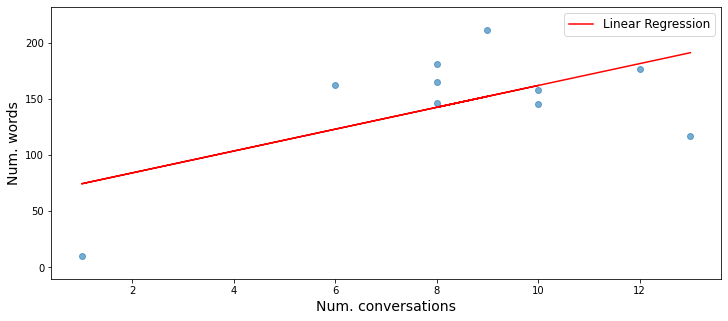

Correlation value 0.9462182275081599
P-value ***
Coefficients: 
 [0.72672073] 
Intercept: 
 -2.605177129748796
R-square: 0.90


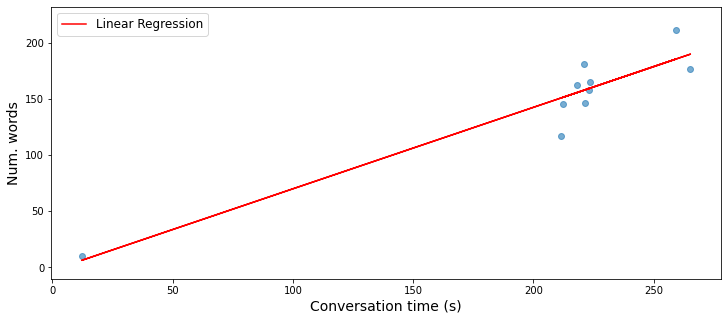

In [11]:
aute.make_scatter_plot(df=df_save, 
                       x_feat="NumConv", x_name="Num. conversations", 
                       y_feat="AllNumWords", y_name="Num. words", 
                       lr_mode=True)

aute.make_scatter_plot(df=df_save, 
                       x_feat="ConvTime_s", x_name="Conversation time (s)", 
                       y_feat="AllNumWords", y_name="Num. words", 
                       lr_mode=True)

Mean All number of words = 147.6 +/- 51.6221 ; Median = 160.5 ; Min. =  10 ; Max. =  212
Mean Person number of words = 75.3 +/- 28.4501 ; Median = 85.0 ; Min. =  2 ; Max. =  113
Mean Bot number of words = 72.3 +/- 27.561 ; Median = 74.5 ; Min. =  8 ; Max. =  104
P-value 0.8228207307418486 string p value -


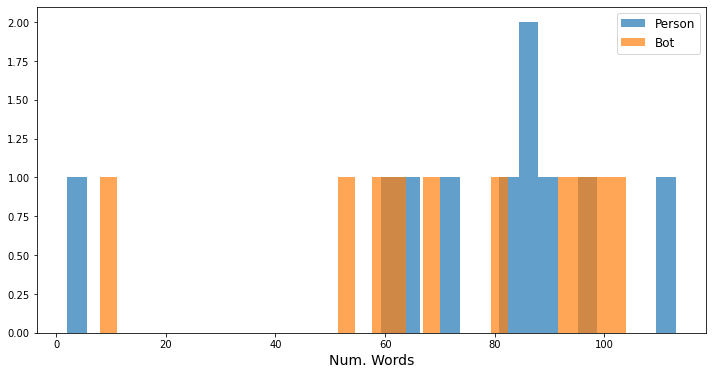

Mean All unique number of words = 60.9 +/- 24.2341 ; Median = 66.5 ; Min. =  5 ; Max. =  92
Mean Person unique words = 39.3 +/- 16.5834 ; Median = 45.0 ; Min. =  1 ; Max. =  59
Mean Bot unique words = 32.3 +/- 15.9941 ; Median = 28.5 ; Min. =  4 ; Max. =  61
P-value 0.3740900213778162 string p value -


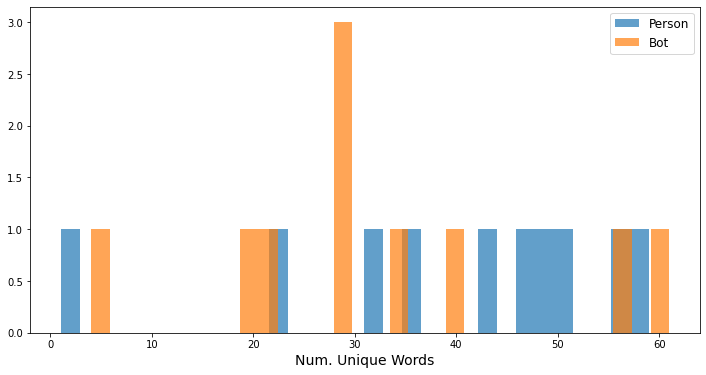

In [12]:
# #######################
# ### Number of words ###
# #######################

aute.stat_print(df_save["AllNumWords"].values, "All number of words")
aute.stat_print(df_save["PersonNumWords"].values, "Person number of words")
aute.stat_print(df_save["BotNumWords"].values, "Bot number of words")
_, p = sc_stats.f_oneway(df_save["PersonNumWords"].values, df_save["BotNumWords"].values)
print("P-value", p, "string p value", aute.get_p_string(p))

plt.figure(figsize=(12, 6))

plt.hist(df_save["PersonNumWords"].values, bins=31, alpha=0.7, label="Person")
plt.hist(df_save["BotNumWords"].values, bins=31, alpha=0.7, label="Bot")
plt.xlabel("Num. Words", fontsize=14)
plt.legend(fontsize=12)

plt.show()

# ####################
# ### Unique words ###
# ####################

aute.stat_print(df_save["AllNumUniqWords"].values, "All unique number of words")
aute.stat_print(df_save["PersonNumUniqWords"].values, "Person unique words")
aute.stat_print(df_save["BotNumUniqWords"].values, "Bot unique words")
_, p = sc_stats.f_oneway(df_save["PersonNumUniqWords"].values, df_save["BotNumUniqWords"].values)
print("P-value", p, "string p value", aute.get_p_string(p))

plt.figure(figsize=(12, 6))

plt.hist(df_save["PersonNumUniqWords"].values, bins=31, alpha=0.7, label="Person")
plt.hist(df_save["BotNumUniqWords"].values, bins=31, alpha=0.7, label="Bot")
plt.xlabel("Num. Unique Words", fontsize=14)
plt.legend(fontsize=12)

plt.show()

#### EDA in times

In [13]:
check_list = []
for df in all_df_list:
    
    dict_data = {
        "NumRows": df.shape[0],
        "NumCols": df.shape[1],
        "TimeConversation_min": (df["S2TEndUnix"].iloc[-1] - df["UnixTimestampLoopInit"].iloc[0])/60,
    }
    
    dict_res = include_time_columns(df, col_name_init="AWSStartUniX", col_name_end="AWSEndUniX", label="AWS")
    dict_data.update(dict_res)
    
    dict_res = include_time_columns(df, col_name_init="S2TStartUnix", col_name_end="S2TEndUnix", label="GoogleS2T")
    dict_data.update(dict_res)
    
    dict_res = include_time_columns(df, col_name_init="BotStartUnix", col_name_end="BotEndUnix", label="OpenAI")
    dict_data.update(dict_res)
    
    check_list.append(dict_data)
    
df_check = pd.DataFrame(check_list)

Mean Number of rows = 17.7 +/- 6.0506 ; Median = 18.0 ; Min. =  3 ; Max. =  26



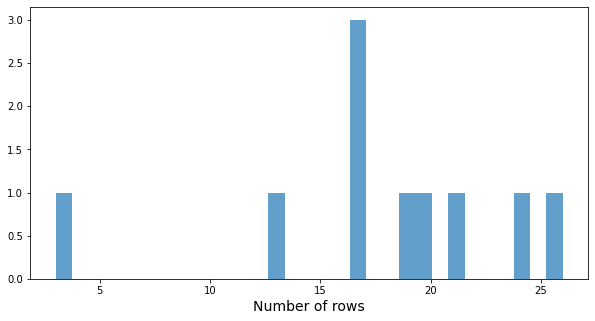

Mean Number of cols = 22.0 +/- 0.0 ; Median = 22.0 ; Min. =  22 ; Max. =  22

Mean Time conversation (min) = 3.8264 +/- 0.42 ; Median = 3.5379 ; Min. =  3.521 ; Max. =  4.4203



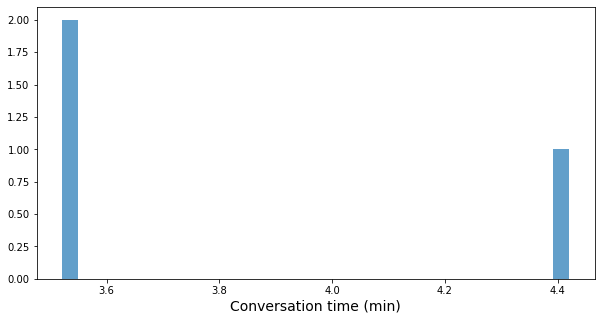

In [14]:
aute.stat_print(df_check["NumRows"], "Number of rows")
print()

plt.figure(figsize=(10, 5))

plt.hist(df_check["NumRows"], bins=31, alpha=0.7)
plt.xlabel("Number of rows", fontsize=14)

plt.show()

aute.stat_print(df_check["NumCols"], "Number of cols")
print()

aute.stat_print(df_check["TimeConversation_min"], "Time conversation (min)")
print()

plt.figure(figsize=(10, 5))

plt.hist(df_check["TimeConversation_min"], bins=31, alpha=0.7)
plt.xlabel("Conversation time (min)", fontsize=14)

plt.show()

Mean Mean_OpenAItime_s = 1.7712 +/- 0.5483 ; Median = 1.7274 ; Min. =  0.7848 ; Max. =  2.669
Mean Mean_AWStime_s = 0.1329 +/- 0.0294 ; Median = 0.1447 ; Min. =  0.0877 ; Max. =  0.1678
Mean Mean_S2Ttime_s = 2.1045 +/- 0.3048 ; Median = 2.0283 ; Min. =  1.7186 ; Max. =  2.7247


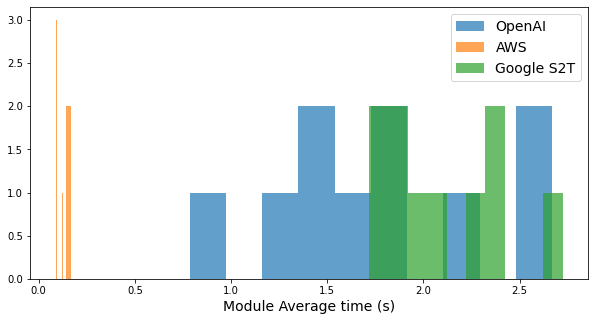

In [15]:
aute.stat_print(df_check["Mean_OpenAI"], "Mean_OpenAItime_s")
aute.stat_print(df_check["Mean_AWS"], "Mean_AWStime_s")
aute.stat_print(df_check["Mean_GoogleS2T"], "Mean_S2Ttime_s")

plt.figure(figsize=(10, 5))

plt.hist(df_check["Mean_OpenAI"], alpha=0.7, label="OpenAI")
plt.hist(df_check["Mean_AWS"], alpha=0.7, label="AWS")
plt.hist(df_check["Mean_GoogleS2T"], alpha=0.7, label="Google S2T")

plt.legend(fontsize=14)
plt.xlabel("Module Average time (s)", fontsize=14)

plt.show()

In [16]:
save_time_dict = {
    "AWS_t": {
        "num_words": [],
        "num_characters": [],
        "time": []
    },
    "Google_S2T": {
        "num_words": [],
        "num_characters": [],
        "time": []
    },
    "OpenAI": {
        "num_words": [],
        "num_characters": [],
        "time": []
    }
}
for df in all_df_list:

    df_person = df[df["Source"]=="Person"]
    df_bot = df[df["Source"]=="Bot"]

    for i in range(df_bot.shape[0]):
        bot_sentence = df_bot["SpanishMessage"].iloc[i]
        num_all_words = len( "".join(re.findall(r'\w+', bot_sentence)) )
        save_time_dict["AWS_t"]["num_words"].append( num_all_words )
        save_time_dict["AWS_t"]["num_characters"].append( len(bot_sentence) )
        save_time_dict["AWS_t"]["time"].append( df_bot["AWSEndUniX"].iloc[i] - df_bot["AWSStartUniX"].iloc[i] )
    
    for i in range(df_person.shape[0]):
        num_all_words = len( "".join(re.findall(r'\w+', df_person["SpanishMessage"].iloc[i])) )
        save_time_dict["Google_S2T"]["num_words"].append( num_all_words )
        save_time_dict["Google_S2T"]["num_characters"].append( len(df_person["SpanishMessage"].iloc[i]) )
        save_time_dict["Google_S2T"]["time"].append( df_person["S2TEndUnix"].iloc[i] - df_person["S2TStartUnix"].iloc[i] )

    for i in range(df_bot.shape[0]):
        num_all_words = len( "".join(re.findall(r'\w+', df_bot["GlobalMessage"].iloc[i])) )
        save_time_dict["OpenAI"]["num_words"].append( num_all_words )
        save_time_dict["OpenAI"]["num_characters"].append( len(df_bot["GlobalMessage"].iloc[i]) )
        save_time_dict["OpenAI"]["time"].append( df_bot["BotTalkEndUnix"].iloc[i] - df_bot["BotTalkStartUnix"].iloc[i] )

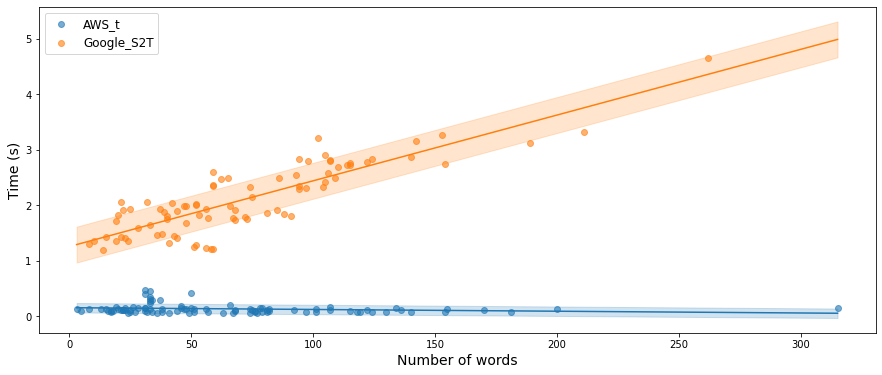

In [17]:
min_num_words = np.min([np.min(v["num_words"]) for k, v in save_time_dict.items() if k is not "OpenAI"])
max_num_words = np.max([np.max(v["num_words"]) for k, v in save_time_dict.items() if k is not "OpenAI"])

plt.figure(figsize=(15, 6))

for i, (k, v) in enumerate(save_time_dict.items()):
    
    if k is not "OpenAI":
    
        sort_x_idx = np.argsort(v["num_words"])
        y_time = np.array(v["time"])[sort_x_idx]
        x_len_text = np.array(v["num_words"])[sort_x_idx]

        x_to_lr = np.array(x_len_text).reshape(-1, 1)
        lr = LinearRegression(n_jobs=-1)
        lr.fit(x_to_lr, y_time)
        y_pred = lr.predict(x_to_lr)

        err_pred = np.sqrt( np.sum((y_time - y_pred)**2)/(len(y_time)-1-1) )
        y_time_plus = y_pred + err_pred
        y_time_minus = y_pred - err_pred

        x_lim_min_max = np.array([max_num_words, min_num_words])
        y_lim_min_max = lr.predict(x_lim_min_max.reshape(-1, 1))

        plt.scatter(x_len_text, y_time, label=k, alpha=0.6, color=aute.PLT_DEFAULT_COLORS[i])
        plt.plot(x_lim_min_max, y_lim_min_max, color=aute.PLT_DEFAULT_COLORS[i])
        plt.fill_between(x_lim_min_max, 
                         y_lim_min_max + err_pred, 
                         y_lim_min_max - err_pred, 
                         alpha=0.2, color=aute.PLT_DEFAULT_COLORS[i])

plt.legend(fontsize=12)
plt.xlabel("Number of words", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)

plt.show()

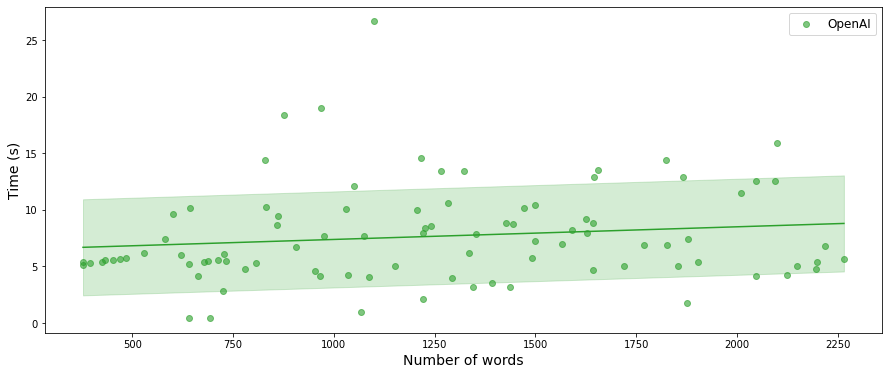

In [18]:
k = "OpenAI"
v = save_time_dict[k]

plt.figure(figsize=(15, 6))
    
sort_x_idx = np.argsort(v["num_words"])
y_time = np.array(v["time"])[sort_x_idx]
x_len_text = np.array(v["num_words"])[sort_x_idx]

x_to_lr = np.array(x_len_text).reshape(-1, 1)
lr = LinearRegression(n_jobs=-1)
lr.fit(x_to_lr, y_time)
y_pred = lr.predict(x_to_lr)

err_pred = np.sqrt( np.sum((y_time - y_pred)**2)/(len(y_time)-1-1) )
y_time_plus = y_pred + err_pred
y_time_minus = y_pred - err_pred


plt.plot(x_len_text, y_pred, color=aute.PLT_DEFAULT_COLORS[i])
plt.scatter(x_len_text, y_time, label=k, alpha=0.6, color=aute.PLT_DEFAULT_COLORS[i])
plt.fill_between(x_len_text, y_time_plus, y_time_minus, alpha=0.2, color=aute.PLT_DEFAULT_COLORS[i])

plt.legend(fontsize=12)
plt.xlabel("Number of words", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)

plt.show()

In [19]:
resource_name_list = ["OpenAItime_s", "AWStime_s", "S2Ttime_s"]
save_time_list = []
counter = 0
for df in all_df_list:
    
    max_index_take = df[df["Source"] == "Bot"].index[-1]
    df_to_study = df.loc[1:(max_index_take+1)].reset_index(drop=True)

    n_iter = (df_to_study.shape[0] // 2)

    for i in range(n_iter):

        delta_aws_t = (df_to_study["AWSEndUniX"].iloc[2*i+1] - df_to_study["AWSStartUniX"].iloc[2*i+1])
        delta_s2t_t = (df_to_study["S2TEndUnix"].iloc[2*i] - df_to_study["S2TStartUnix"].iloc[2*i])
        delta_bot_t = (df_to_study["BotEndUnix"].iloc[2*i+1] - df_to_study["BotStartUnix"].iloc[2*i+1])

        total_time = df_to_study["BotTalkStartUnix"].iloc[2*i+1] - df_to_study["PersonTalkEndUnix"].iloc[2*i]
        rest_time = total_time - delta_bot_t - delta_s2t_t - delta_aws_t

        all_times_list = [
            (delta_aws_t, "AWS"), 
            (delta_s2t_t, "S2T"), 
            (delta_bot_t, "OpenAI"), 
            (total_time, "Total"), 
            (rest_time, "Rest")
        ]
        
        for elt in all_times_list:
            save_time_list.append({
                "Iteration": counter,
                "Source": elt[1],
                "Time": elt[0]
            })

        counter += 1
        
df_times = pd.DataFrame(save_time_list)
print("Shape", df_times.shape)

Shape (410, 3)


In [20]:
all_times_list = []
for g, df_g in df_times.groupby("Iteration"):
    dict_times = dict(zip(df_g["Source"].values.tolist(), df_g["Time"].values.tolist()))
    all_times_list.append(dict_times)
df_all_t_sources = pd.DataFrame(all_times_list)

df_all_t_sources.to_csv("../Documents/ResultsTable/SaveToBoxplot.csv", index=False)

In [21]:
for col in df_all_t_sources.columns:
    print("Source", col, "takes:")
    aute.stat_print(df_all_t_sources[col], col)
    print("In percentage", np.round(100 * np.sum(df_all_t_sources[col])/np.sum(df_all_t_sources["Total"]), 4), "%")
    print()

Source AWS takes:
Mean AWS = 0.1057 +/- 0.0328 ; Median = 0.1067 ; Min. =  0.0618 ; Max. =  0.2062
In percentage 1.8975 %

Source S2T takes:
Mean S2T = 2.127 +/- 0.6285 ; Median = 1.9798 ; Min. =  1.1978 ; Max. =  4.6505
In percentage 38.1861 %

Source OpenAI takes:
Mean OpenAI = 2.0131 +/- 1.1616 ; Median = 1.7881 ; Min. =  0.0 ; Max. =  7.3353
In percentage 36.1403 %

Source Total takes:
Mean Total = 5.5702 +/- 1.6728 ; Median = 5.5394 ; Min. =  2.5056 ; Max. =  12.3265
In percentage 100.0 %

Source Rest takes:
Mean Rest = 1.3244 +/- 1.1363 ; Median = 1.0077 ; Min. =  0.4012 ; Max. =  8.9369
In percentage 23.7761 %



In [22]:
all_diff = df_all_t_sources["Total"] - np.sum(df_all_t_sources[["Rest", "OpenAI", "S2T", "AWS"]], axis=1)
np.max(all_diff)

0.0

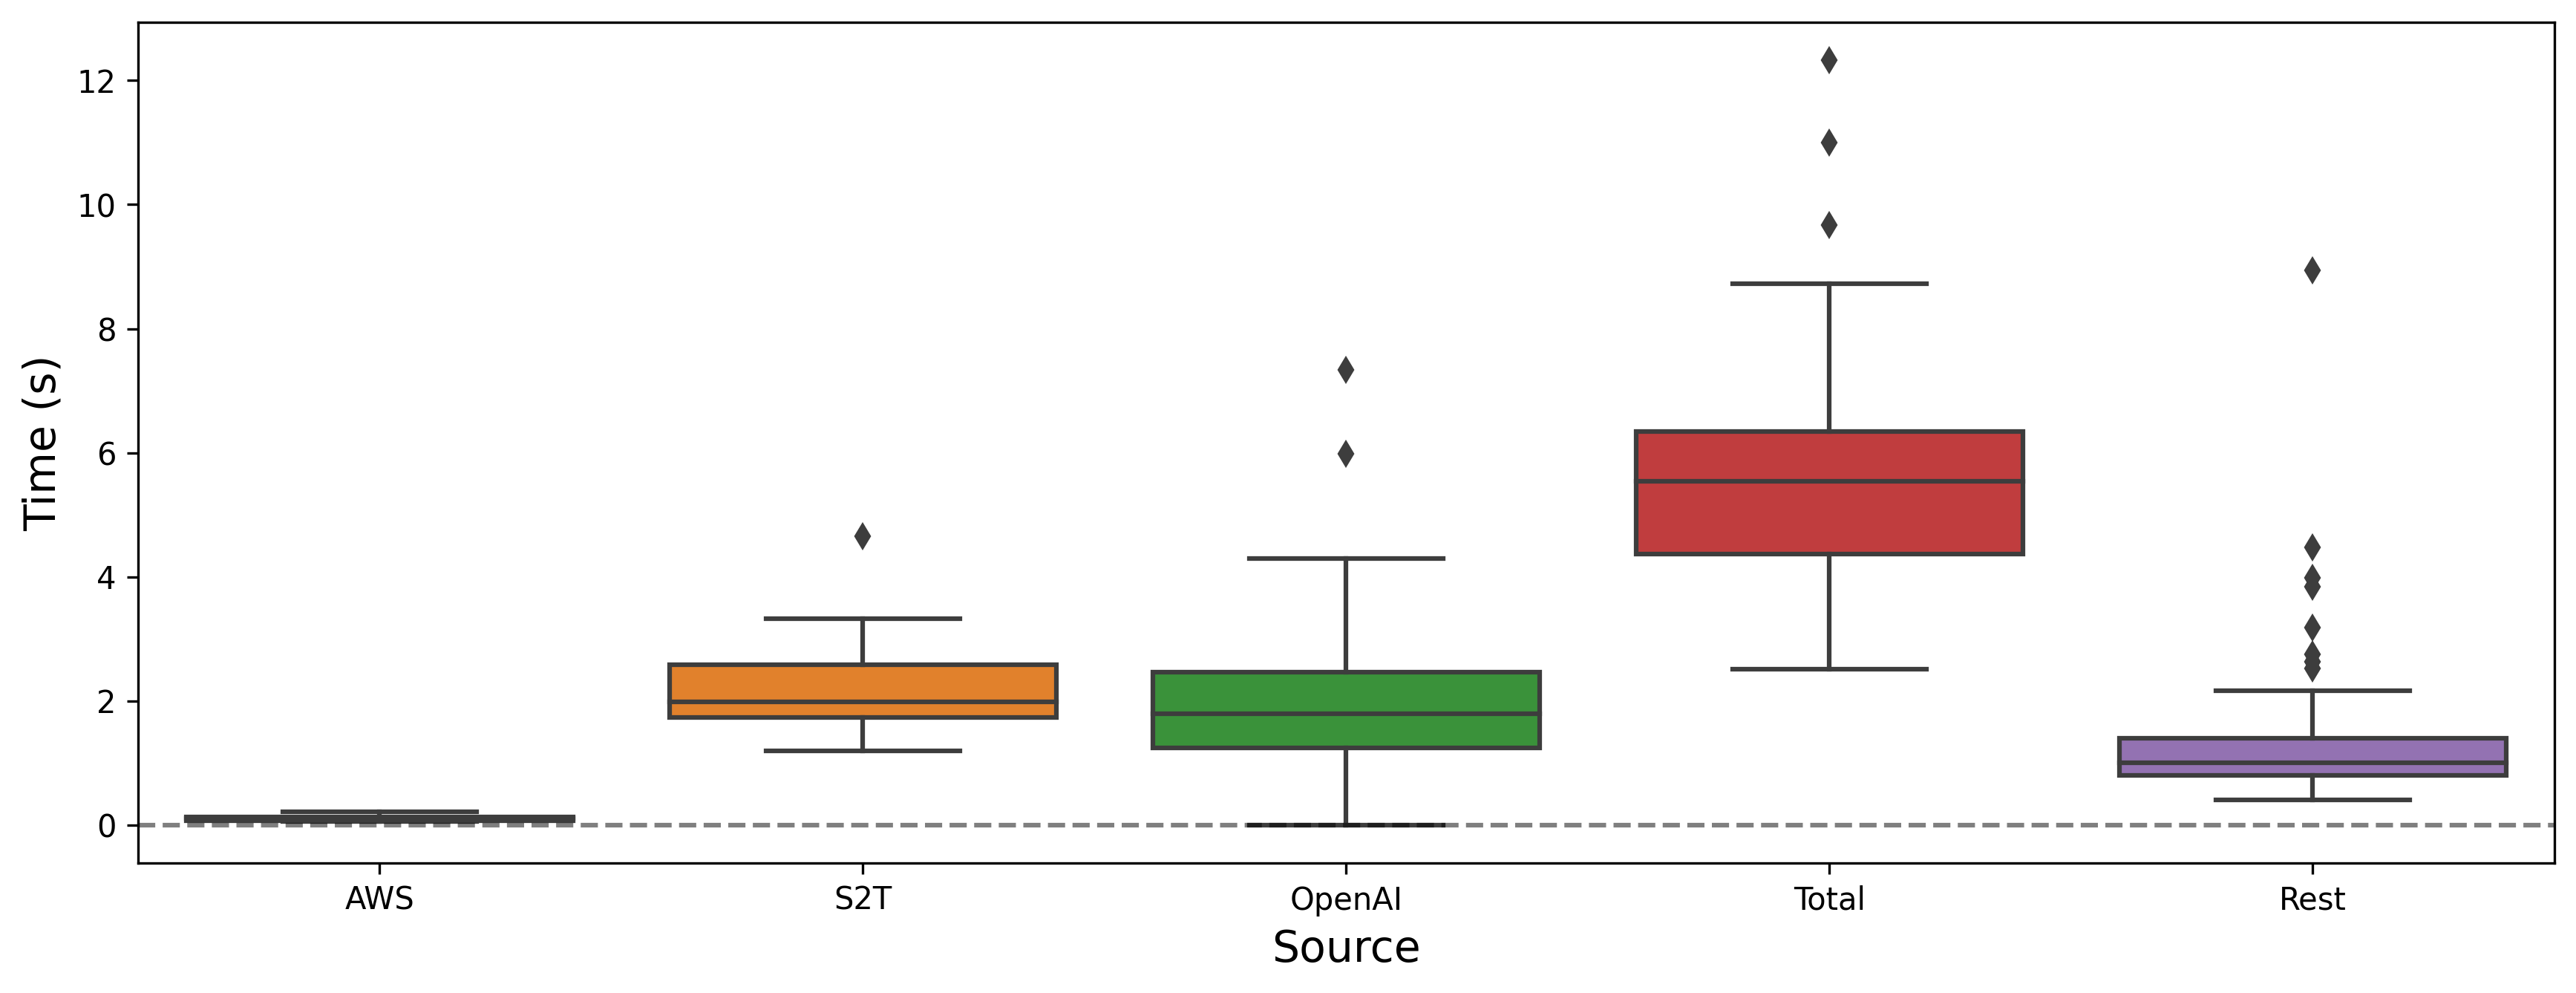

In [23]:
plt.figure(figsize=(14, 5), dpi=300)
sns.boxplot(x="Source", y="Time", data=df_times)

plt.axhline(0, c="black", linestyle="--", alpha=0.5)

plt.xlabel("Source", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)

plt.savefig('../Documents/Images/save_boxplot.pdf', format='pdf', dpi=300)

plt.show()

### Crude Text 

#### Token size analysis

In [24]:
def obtain_word_analysis(data, target):
    result_list = []
    for text in data[target].tolist():
        
        original_text_clean = clean_text(text, subject_name=None, use_stemmer=False)
        sentence_list = [sentence for sentence in original_text_clean.split(".") if len(sentence) > 1]
        len_list = [len(sent.split()) for sent in sentence_list]
        
        result_list.append({
            "mean": np.mean(len_list),
            "median": np.median(len_list),
            "std": np.std(len_list),
            "num_words_in_sentence": len_list
        })

    return pd.DataFrame(result_list)

Mean Number of words for BOT by sentence = 8.8824 +/- 5.8286 ; Median = 8.0 ; Min. =  1 ; Max. =  26
Mean Number of words for Person by sentence = 14.9904 +/- 10.608 ; Median = 12.0 ; Min. =  2 ; Max. =  67
P-value 1.1299472912532947e-08 string p value ***


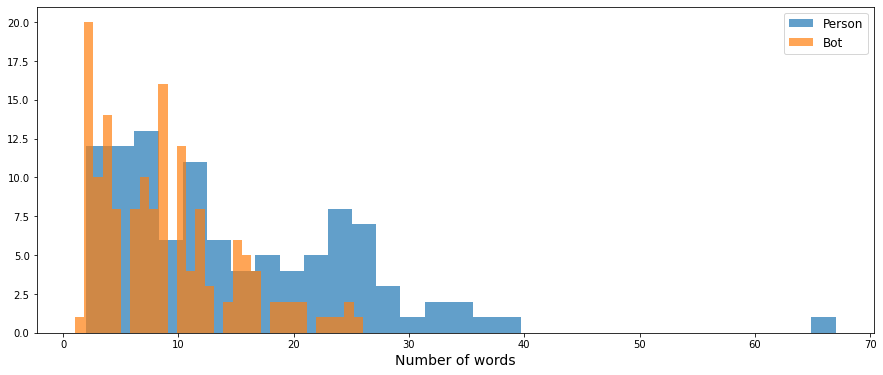

In [25]:
df_bot_result = obtain_word_analysis(df_save, "BotOriginalText")
df_person_result = obtain_word_analysis(df_save, "PersonOriginalText")

bot_word_number = []
for my_list in df_bot_result["num_words_in_sentence"].tolist():
    bot_word_number += my_list

person_word_number = []
for my_list in df_person_result["num_words_in_sentence"].tolist():
    person_word_number += my_list

aute.stat_print(bot_word_number, "Number of words for BOT by sentence")
aute.stat_print(person_word_number, "Number of words for Person by sentence")

_, p = sc_stats.f_oneway(person_word_number, bot_word_number)
print("P-value", p, "string p value", aute.get_p_string(p))

plt.figure(figsize=(15, 6))

plt.hist(person_word_number, bins=31, alpha=0.7, label="Person")
plt.hist(bot_word_number, bins=31, alpha=0.7, label="Bot")
plt.xlabel("Number of words", fontsize=14)
plt.legend(fontsize=12)

plt.show()

Mean Number of words for ALL by sentence = 11.3541 +/- 8.6629 ; Median = 9.0 ; Min. =  1 ; Max. =  67


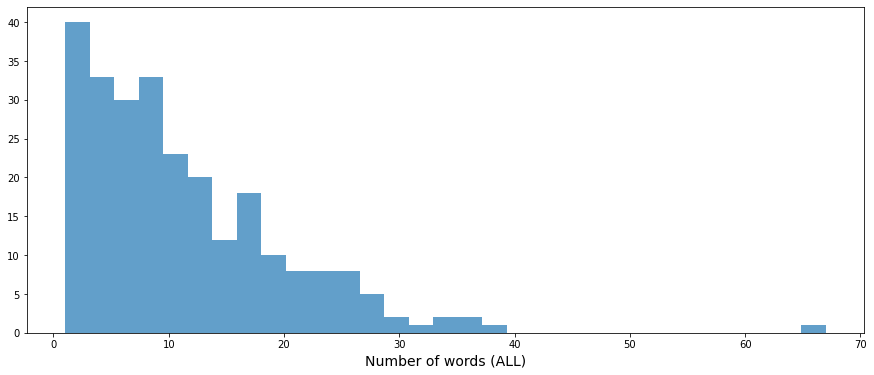

In [26]:
df_all_result = obtain_word_analysis(df_save, "AllOriginalText")

all_word_number = []
for my_list in df_all_result["num_words_in_sentence"].tolist():
    all_word_number += my_list

aute.stat_print(all_word_number, "Number of words for ALL by sentence")

plt.figure(figsize=(15, 6))

plt.hist(all_word_number, bins=31, alpha=0.7, label="All")
plt.xlabel("Number of words (ALL)", fontsize=14)

plt.show()

## Study by personalities

In the following section it will be studied the time spend, number of words, time between senteces etc in terms of the personality.

In [27]:
uniq_config_name = df_save["ConfigName"].unique()

In [39]:
save_personality_res_list = []
for personality_label in uniq_config_name:
    
    print("Personality", personality_label)
    
    study_pers_list = [df_check for df_check in all_df_list if personality_label == df_check["ConfigName"].iloc[0]]
    df_study = pd.concat(study_pers_list).reset_index(drop=True)
    
    for i in range(df_study.shape[0]):
        source = df_study["Source"].iloc[i]
        
        gender_check = personality_label.split("_")[1]
        if gender_check == "Male":
            gender = "Man"
        elif gender_check == "Female":
            gender = "Woman"
        else:
            gender = gender_check
            
        save_personality_res_list.append({
            "Label": personality_label,
            "Personality": personality_label.split("_")[0],
            "Gender": gender,
            "GenderBotId": personality_label.split("_")[2],
            "Source": source,
            "SibjectId": df_study["SubjectId"].iloc[i],
            "DeltaTimeTalk": df_study[source + "TalkEndUnix"].values[i] - df_study[source + "TalkStartUnix"].values[i],
            "NumWordsUsed": len(df_study["SpanishMessage"].values[i].split())
        })
        
df_met_by_sent = pd.DataFrame(save_personality_res_list)
print("Shape", df_met_by_sent.shape)
print("Columns", df_met_by_sent.columns)
display(df_met_by_sent.head(5))

Personality Neutral_Female_1
Personality Neutral_Female_2
Personality Happy_Man_1
Personality Neutral_Male_2
Personality Angry_Woman_1
Personality Relax_Man_2
Personality Happy_Woman_2
Personality Sad_Man_1
Shape (177, 8)
Columns Index(['Label', 'Personality', 'Gender', 'GenderBotId', 'Source', 'SibjectId',
       'DeltaTimeTalk', 'NumWordsUsed'],
      dtype='object')


,Label,Personality,Gender,GenderBotId,Source,SibjectId,DeltaTimeTalk,NumWordsUsed
0,Neutral_Female_1,Neutral,Woman,1,Bot,Jose112,5.114554,9
1,Neutral_Female_1,Neutral,Woman,1,Person,Jose112,6.385868,12
2,Neutral_Female_1,Neutral,Woman,1,Bot,Jose112,5.536518,6
3,Neutral_Female_1,Neutral,Woman,1,Person,Jose112,6.358276,11
4,Neutral_Female_1,Neutral,Woman,1,Bot,Jose112,6.173038,6


### Studying person

P-value 0.7030898922506584 with significance -


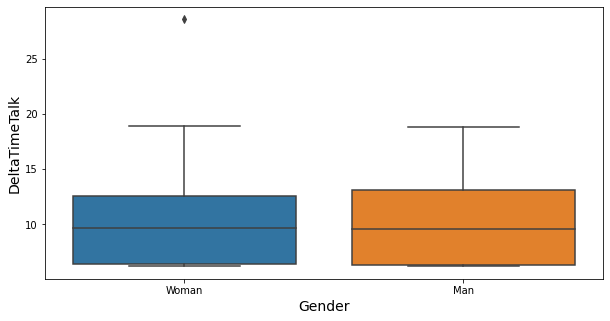

P-value 0.16600063683963576 with significance -


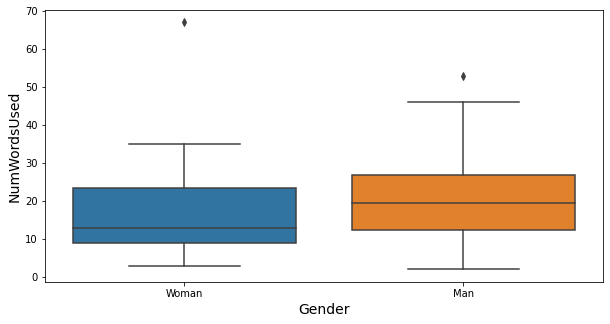

In [44]:
df_to_plot = df_met_by_sent[df_met_by_sent["Source"] == "Person"]

# Check differences between the time talking between the male and female bot.

aute.make_binary_plot(data=df_to_plot, 
                      x_feat="Gender", x_name="Gender", 
                      y_feat="DeltaTimeTalk", y_name="DeltaTimeTalk")

# -------------------------------------------------------------------------------

# Check differences between the number of words used between the male and female bot.

aute.make_binary_plot(data=df_to_plot, 
                      x_feat="Gender", x_name="Gender", 
                      y_feat="NumWordsUsed", y_name="NumWordsUsed")

P-value 0.0582380332012486 with significance -


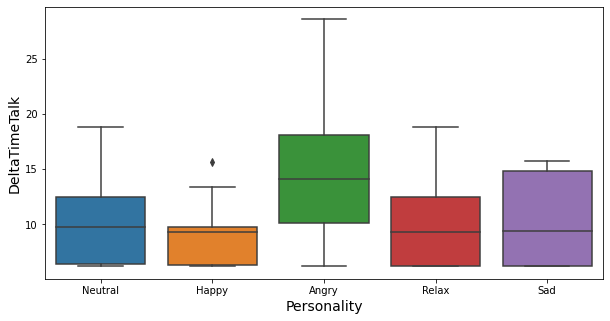

P-value 0.3156835792217831 with significance -


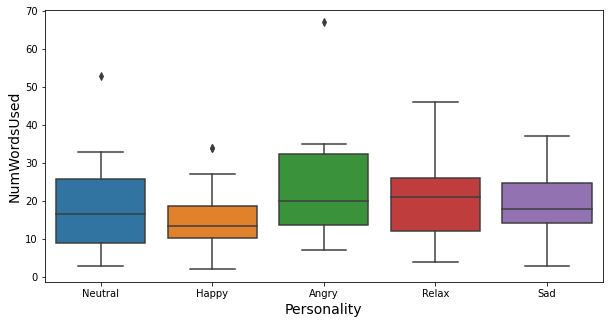

In [45]:
df_to_plot = df_met_by_sent[df_met_by_sent["Source"] == "Person"]

# Check differences between the time talking between the male and female bot.

aute.make_binary_plot(data=df_to_plot, 
                      x_feat="Personality", x_name="Personality", 
                      y_feat="DeltaTimeTalk", y_name="DeltaTimeTalk")

# -------------------------------------------------------------------------------

# Check differences between the number of words used between the male and female bot.

aute.make_binary_plot(data=df_to_plot, 
                      x_feat="Personality", x_name="Personality", 
                      y_feat="NumWordsUsed", y_name="NumWordsUsed")

P-value 0.2344481870141496 with significance -


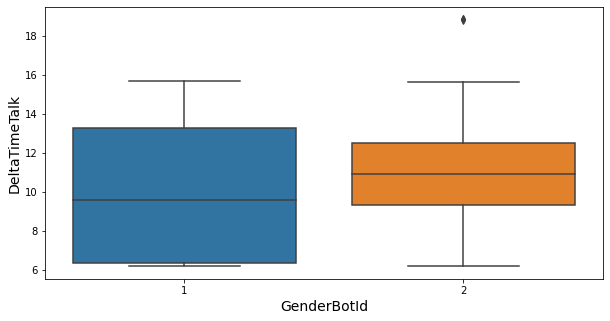

P-value 0.140358266180809 with significance -


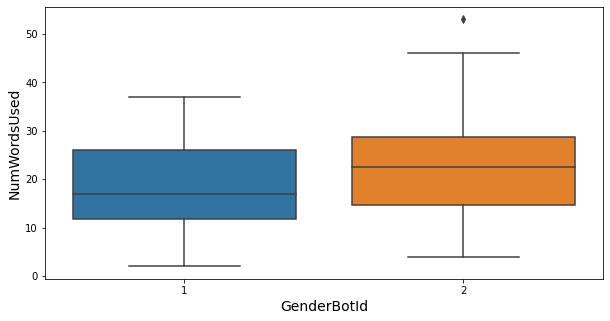

P-value 0.37686033111851525 with significance -


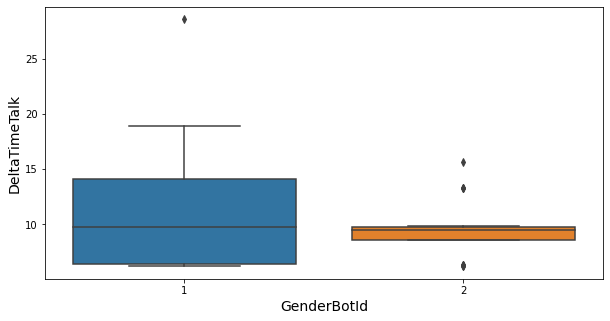

P-value 0.8566734391026909 with significance -


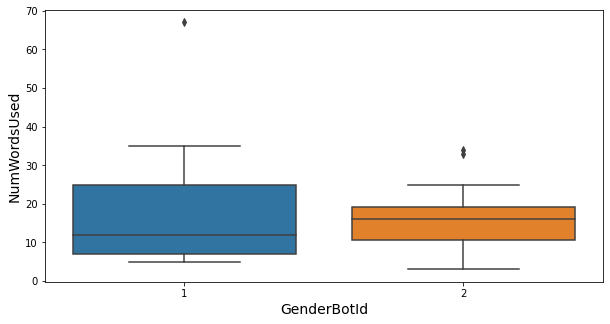

In [47]:
df_to_plot = df_met_by_sent[(df_met_by_sent["Source"] == "Person") & (df_met_by_sent["Gender"] == "Man")]

# Check differences between the time talking between the male and female bot.

aute.make_binary_plot(data=df_to_plot, 
                      x_feat="GenderBotId", x_name="GenderBotId", 
                      y_feat="DeltaTimeTalk", y_name="DeltaTimeTalk")

# -------------------------------------------------------------------------------

# Check differences between the number of words used between the male and female bot.

aute.make_binary_plot(data=df_to_plot, 
                      x_feat="GenderBotId", x_name="GenderBotId", 
                      y_feat="NumWordsUsed", y_name="NumWordsUsed")

# -------------------------------------------------------------------------------

df_to_plot = df_met_by_sent[(df_met_by_sent["Source"] == "Person") & (df_met_by_sent["Gender"] == "Woman")]

# Check differences between the time talking between the male and female bot.

aute.make_binary_plot(data=df_to_plot, 
                      x_feat="GenderBotId", x_name="GenderBotId", 
                      y_feat="DeltaTimeTalk", y_name="DeltaTimeTalk")

# -------------------------------------------------------------------------------

# Check differences between the number of words used between the male and female bot.

aute.make_binary_plot(data=df_to_plot, 
                      x_feat="GenderBotId", x_name="GenderBotId", 
                      y_feat="NumWordsUsed", y_name="NumWordsUsed")

### Studying Avatar

P-value 0.04468501281278529 with significance *


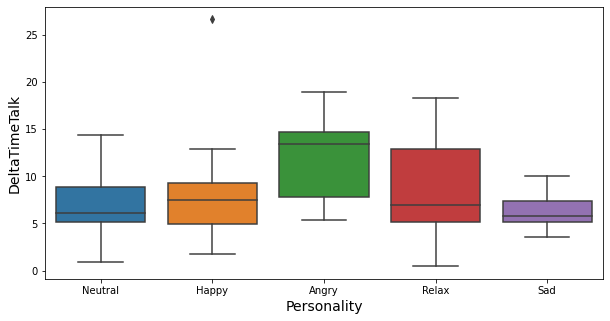

P-value 0.012102543088044199 with significance *


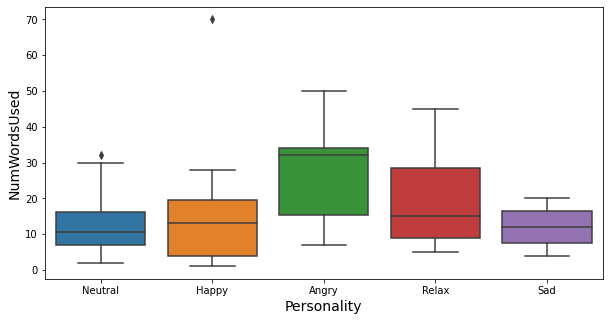

In [49]:
df_to_plot = df_met_by_sent[df_met_by_sent["Source"] == "Bot"]

# Check differences between the time talking between the male and female bot.

aute.make_binary_plot(data=df_to_plot, 
                      x_feat="Personality", x_name="Personality", 
                      y_feat="DeltaTimeTalk", y_name="DeltaTimeTalk")

# -------------------------------------------------------------------------------

# Check differences between the number of words used between the male and female bot.

aute.make_binary_plot(data=df_to_plot, 
                      x_feat="Personality", x_name="Personality", 
                      y_feat="NumWordsUsed", y_name="NumWordsUsed")

## WordCloud analysis

- Falta tokenizar las palabras, eliminar acentos y etc.

- Estaria bien establecer un protocolo para eliminar el nombre del sujeto.

- Estudiar el número y cuales son las stopwords localizadas en el Bot y en la persona. Ver si estas stopwords son las mismas para ambos o distintas, etc. Posiblemente el sujeto utilice más stopwords que el sujeto o quizá no. 

### Whole text

In [28]:
whole_text = " ".join(df_save["AllOriginalText"]).replace(".", " ").replace(",", " ").lower()

all_words_list = [word for word in whole_text.split() if word not in spanish_stopwords_th]
uniq_words_list = list(set(all_words_list))
freq_words_appear = [
    {"Word": word, "Times": np.sum(np.array(all_words_list)==word)} for word in uniq_words_list
]
df_freq_all_words = pd.DataFrame(freq_words_appear).sort_values("Times", ascending=False).reset_index(drop=True)
df_freq_all_words.head(15)

,Word,Times
0,gusta,16
1,valencia,11
2,tú?,7
3,hola,7
4,ir,7
5,nombre,7
6,bueno,7
7,ciudad,6
8,tiempo,6
9,encanta,6


In [29]:
print("Number of different words", df_freq_all_words.shape[0])
print("Mean frequency", np.round(np.mean(df_freq_all_words["Times"]), 5), 
      "+/-", np.round(np.std(df_freq_all_words["Times"]), 5), 
      "Max", np.max(df_freq_all_words["Times"]), 
      "Min", np.min(df_freq_all_words["Times"]) )

Number of different words 312
Mean frequency 1.72436 +/- 1.56923 Max 16 Min 1


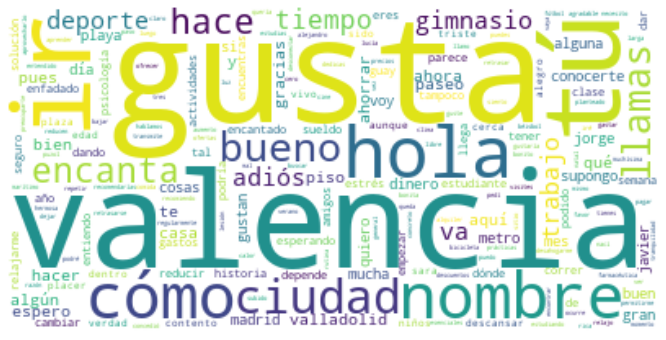

In [30]:
plt.figure(figsize=(15, 6))

all_wordcloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(all_words_list))

plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Bot analysis

In [31]:
whole_bot_text = " ".join(df_save["BotOriginalText"]).replace(".", " ").replace(",", " ").lower()

all_bot_words_list = [word for word in whole_bot_text.split() if word not in spanish_stopwords_th]
uniq_bot_words_list = list(set(all_bot_words_list))
freq_bot_words_appear = [
    {"Word": word, "Times": np.sum(np.array(all_bot_words_list)==word)} for word in uniq_bot_words_list
]
df_freq_bot_words = pd.DataFrame(freq_bot_words_appear).sort_values("Times", ascending=False).reset_index(drop=True)
df_freq_bot_words.head(15)

,Word,Times
0,gusta,12
1,tú?,7
2,valencia,7
3,nombre,6
4,ciudad,6
5,¿cómo,6
6,llamas,6
7,hola,6
8,¿te,4
9,tiempo,4


In [32]:
print("Number of different words", df_freq_bot_words.shape[0])
print("Mean frequency", np.round(np.mean(df_freq_bot_words["Times"]), 5), 
      "+/-", np.round(np.std(df_freq_bot_words["Times"]), 5), 
      "Max", np.max(df_freq_bot_words["Times"]), 
      "Min", np.min(df_freq_bot_words["Times"]) )

Number of different words 249
Mean frequency 1.56627 +/- 1.285 Max 12 Min 1


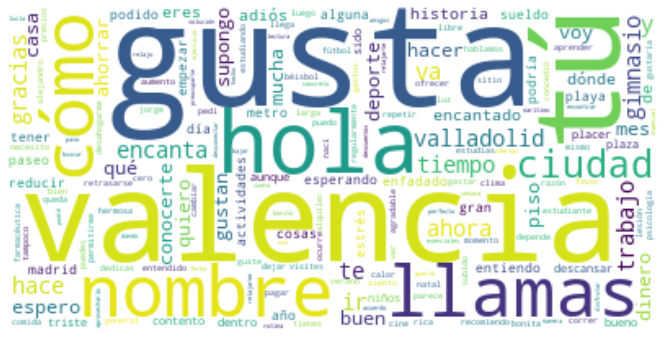

In [33]:
plt.figure(figsize=(15, 6))

all_wordcloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(all_bot_words_list))

plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Analysis against Questionare

In [40]:
random_target = [np.random.randint(1, 5+1) for _ in range(df_save.shape[0])]
random_binary_target = [np.random.randint(0, 1+1) for _ in range(df_save.shape[0])]

In [41]:
df_save["MultilabelTarget"] = random_target
df_save["BinaryTarget"] = random_binary_target

In [42]:
aute.stat_print(df_save["MultilabelTarget"], "Realism degree score", precision=2)
aute.stat_print(100 * df_save["BinaryTarget"], "Repetition score", precision=2)

Mean Realism degree score = 2.38 +/- 1.41 ; Median = 2.0 ; Min. =  1 ; Max. =  5
Mean Repetition score = 62.5 +/- 48.41 ; Median = 100.0 ; Min. =  0 ; Max. =  100


In [43]:
print("Columns", df_save.columns)
df_save.head(5)

Columns Index(['SubjectId', 'FirstDate', 'LastDate', 'ConvTime_s', 'NumConv',
       'NumSamples', 'AllText', 'AllNumUniqWords', 'AllOriginalText',
       'AllNumWords', 'BotText', 'BotNumUniqWords', 'BotOriginalText',
       'BotNumWords', 'PersonText', 'PersonNumUniqWords', 'PersonOriginalText',
       'PersonNumWords', 'Mean_OpenAI', 'Max_OpenAI', 'Min_OpenAI',
       'Diff_OpenAI', 'Mean_AWS', 'Max_AWS', 'Min_AWS', 'Diff_AWS',
       'Mean_BotTalk', 'Max_BotTalk', 'Min_BotTalk', 'Diff_BotTalk',
       'Mean_PersonTalk', 'Max_PersonTalk', 'Min_PersonTalk',
       'Diff_PersonTalk', 'MultilabelTarget', 'BinaryTarget'],
      dtype='object')


,SubjectId,FirstDate,LastDate,ConvTime_s,NumConv,NumSamples,AllText,AllNumUniqWords,AllOriginalText,AllNumWords,...,Mean_BotTalk,Max_BotTalk,Min_BotTalk,Diff_BotTalk,Mean_PersonTalk,Max_PersonTalk,Min_PersonTalk,Diff_PersonTalk,MultilabelTarget,BinaryTarget
0,Alejandro,1.665395e+09,1.665395e+09,215.250305,9,18,"hola, nombr llam tu. hola, llam alex. hol alex...",63,"Hola, mi nombre es ¿Cómo te llamas tú?. hola, ...",141,...,7.453963,10.633201,4.429088,2.223547,11.541201,15.850620,6.194982,6.362520,1,0
1,Alejandro,1.665395e+09,1.665396e+09,282.038996,15,30,"hola, nombr alejandr llam tu. miriam alejandro...",91,"Hola, mi nombre es Alejandro ¿Cómo te llamas t...",183,...,7.409354,26.951323,2.648327,-2.325912,7.086196,15.840486,6.203408,0.012190,4,1
2,Alejandro,1.665396e+09,1.665396e+09,163.489967,9,18,"hola, nombr mari llam tu. hol mari alex tal. h...",46,"Hola, mi nombre es ¿Cómo te llamas tú?. hola s...",97,...,5.918260,9.524444,2.164783,-2.980209,8.761743,22.374247,6.223196,3.207338,3,1
3,Alejandro,1.665396e+09,1.665396e+09,155.050430,7,14,"hola, nombr daniel llam tu. gabriel dicho. ah,...",56,"Hola, mi nombre es Daniel ¿Cómo te llamas tú?....",105,...,8.193665,21.867001,4.763348,0.713056,9.479692,22.408216,6.225244,0.012462,5,0
4,Alejandro,1.665396e+09,1.665397e+09,150.900022,5,10,"hola, nombr mart llam tu. buenas, marta, llam ...",48,"Hola, mi nombre es Marta ¿Cómo te llamas tú?. ...",100,...,14.929486,25.502450,5.474934,20.027516,8.812869,15.867685,6.225132,-0.014510,1,1


In [44]:
aute.make_scatter_plot(df=df_save, 
                       x_feat="BotTimeAns", x_name="Bot Time Answer (s)", 
                       y_feat="MultilabelTarget", y_name="Degree of realism", 
                       lr_mode=True)

aute.make_scatter_plot(df=df_save, 
                       x_feat="NumSamples", x_name="Number of sentences", 
                       y_feat="MultilabelTarget", y_name="Degree of realism", 
                       lr_mode=True)

aute.make_scatter_plot(df=df_save, 
                       x_feat="BotNumUniqWords", x_name="Number of Bot unique words", 
                       y_feat="MultilabelTarget", y_name="Degree of realism", 
                       lr_mode=True)

aute.make_scatter_plot(df=df_save, 
                       x_feat="BotNumWords", x_name="Number of Bot words", 
                       y_feat="MultilabelTarget", y_name="Degree of realism", 
                       lr_mode=True)

KeyError: "['BotTimeAns'] not in index"

In [ ]:
aute.make_binary_plot(data=df_save, 
                      x_feat="BinaryTarget", x_name="Binary Target", 
                      y_feat="BotTimeAns", y_name="Bot time answer (s)", 
                      violin_plot=True)

aute.make_binary_plot(data=df_save, 
                      x_feat="BinaryTarget", x_name="Binary Target", 
                      y_feat="NumSamples", y_name="Num. sentences", 
                      violin_plot=True)

aute.make_binary_plot(data=df_save, 
                      x_feat="BinaryTarget", x_name="Binary Target", 
                      y_feat="BotNumUniqWords", y_name="Bot number unique words", 
                      violin_plot=True)

aute.make_binary_plot(data=df_save, 
                      x_feat="BinaryTarget", x_name="Binary Target", 
                      y_feat="BotNumWords", y_name="Bot number words", 
                      violin_plot=True)

## Study sentence similarity

In [ ]:
# ### Bot ###

all_bot_sentence_list = []
for sent in df_save["BotOriginalText"].tolist():
    all_bot_sentence_list += sent.split(". ")

save_vector_list = []
for sent in all_bot_sentence_list:
    doc_sent_nlp = nlp_spanish(sent)
    if doc_sent_nlp.vector.shape[0] > 0:
        save_vector_list.append( doc_sent_nlp.vector/doc_sent_nlp.vector_norm )
    
save_res_similarity_bot_list = []
for i, i_sent in enumerate(save_vector_list[:-1]):
    for j_sent in save_vector_list[(i+1):]:
        save_res_similarity_bot_list.append(
            aute.cosine_similarity(i_sent, j_sent)
        )
        
# ### Person ###
        
all_person_sentence_list = []
for sent in df_save["PersonOriginalText"].tolist():
    all_person_sentence_list += sent.split(". ")

save_vector_list = []
for sent in all_person_sentence_list:
    doc_sent_nlp = nlp_spanish(sent)
    if doc_sent_nlp.vector.shape[0] > 0:
        save_vector_list.append( doc_sent_nlp.vector/doc_sent_nlp.vector_norm )
    
save_res_similarity_person_list = []
for i, i_sent in enumerate(save_vector_list[:-1]):
    for j_sent in save_vector_list[(i+1):]:
        save_res_similarity_person_list.append(
            aute.cosine_similarity(i_sent, j_sent)
        )

In [ ]:
aute.stat_print(save_res_similarity_bot_list, "Bot sentence similarity")
aute.stat_print(save_res_similarity_person_list, "Person sentence similarity")

plt.figure(figsize=(15, 6))

plt.hist(save_res_similarity_bot_list, bins=31, alpha=0.7, label="Bot")
plt.hist(save_res_similarity_person_list, bins=31, alpha=0.7, label="Person")

plt.legend(fontsize=14)

plt.show()

### Circle plot

In [ ]:
all_subj_states_1 = np.array([np.random.randint(0, 2, size=2) for i in range(50)])
mean_states_1 = np.mean(all_subj_states_1, axis=0)
std_states_1 = np.std(all_subj_states_1, axis=0)

all_subj_states_2 = np.array([np.random.randint(-1, 1, size=2) for i in range(50)])
mean_states_2 = np.mean(all_subj_states_2, axis=0)
std_states_2 = np.std(all_subj_states_2, axis=0)

all_subj_states_3 = np.array([np.random.randint(-1, 2, size=2) for i in range(50)])
mean_states_3 = np.mean(all_subj_states_3, axis=0)
std_states_3 = np.std(all_subj_states_3, axis=0)

all_subj_states_4 = np.array([np.random.randint(-2, 2, size=2) for i in range(50)])
mean_states_4 = np.mean(all_subj_states_4, axis=0)
std_states_4 = np.std(all_subj_states_4, axis=0)

In [ ]:
circle2 = plt.Circle((0, 0), 2, color='blue', fill=False, linewidth=2, alpha=0.7)

fig, ax = plt.subplots(figsize=(8, 8)) # note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
# fig = plt.gcf()
# ax = fig.gca()

plt.errorbar(mean_states_1[0], mean_states_1[1], 
             xerr=std_states_1[0], yerr=std_states_1[1], 
             marker='o', capsize=5, linestyle="--", label="Happy")

plt.errorbar(mean_states_2[0], mean_states_2[1], 
             xerr=std_states_2[0], yerr=std_states_2[1], 
             marker='o', capsize=5, linestyle="--", label="Sad")

plt.errorbar(mean_states_3[0], mean_states_3[1], 
             xerr=std_states_3[0], yerr=std_states_3[1], 
             marker='o', capsize=5, linestyle="--", label="Relax")

plt.errorbar(mean_states_4[0], mean_states_4[1], 
             xerr=std_states_4[0], yerr=std_states_4[1], 
             marker='o', capsize=5, label="Angry")

ax.add_patch(circle2)

plt.axvline(0, c="black", alpha=0.7)
plt.axhline(0, c="black", alpha=0.7)

plt.legend(fontsize=12)

plt.xlim(-2.1, 2.1)
plt.ylim(-2.1, 2.1)

plt.show()

### Classifier

- Hacer un clasificador que sepa o pueda descubrir por las métricas obtenidas de la conversación si es un Bot o una persona. Lo interesante sería que NO.